In [233]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection for content losses done by Logistic Regression

Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [234]:
import os, sys
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split,StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # make sure not to mix it with sklearn Pipeline
from collections import Counter

import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines_discretize as p


s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))


import warnings
warnings.filterwarnings('ignore')



In [235]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 44)


,Target_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,contaminations_light,contaminations_heavy,shp_content_value_euro,elevation_m,shp_registered_capital_euro
395,0.0,4.0,70.0,0,1,NaN,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,3.0,3.0,1.0,5,1.0,2.0,1,0,NaN,1.83886,11047.7
396,0.0,3.0,100.0,0,1,NaN,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,3.0,4.0,NaN,5,NaN,3.0,1,0,NaN,1.87277,736.5


In [236]:
## delete features with more than 10% missing values

#df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.15]]  # drop feautres with more than 10% missing values
#print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 
## --> kepp threshold by 15% less would delete important features e.g. content values, registerd capitaletc.

# drop warning time due to 77% nan
df_candidates = df_candidates.drop("warning_time_h", axis=1)

Percentage of missing valeus per feature
 warning_time_h                                 0.775819
elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.158690
shp_registered_capital_euro                    0.118388
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
hh_monthly_income_cat                          0.060453
shp_monetary_resources4prevention              0.045340
resilience_city_protection                     0.037783
Target_contentloss_euro                        0.037783
resilience_neighbor_management                 0.027708
inundation_duration_h                          0.022670
elevation_m                                    0.010076
b_area                                         0.005038
dtype: float64


In [237]:
print(df_candidates.isna().sum().sort_values(ascending=False)[:10])# remaining abs number of nan per feature

elevation_building_height_cm                   63
shp_content_value_euro                         63
shp_registered_capital_euro                    47
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
hh_monthly_income_cat                          24
shp_monetary_resources4prevention              18
resilience_city_protection                     15
Target_contentloss_euro                        15
dtype: int64


#### Hyperparamters

## Fit model and select features

In [238]:
## Hyperparameter ranges to test
weights = np.linspace(0.0, 0.99, 300) #2 # class weight range
param_grid = {
     "model__penalty": ["elasticnet"],      # use only elastic net regularization as alternative part to business reduction with Elastic net
    # "model__penalty": ["none", "l1", "l2", "elasticnet"],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "model__tol": [0.0001, 0.001, 0.01, 0.1, 0.5,],
    "model__C": [1,2,3,4],  # inverse regularization strength
    "model__max_iter": [1,2,3,4],
    #l1_ratio=1
    "model__l1_ratio": np.arange(0.0, 1, 0.25),     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "model__solver": ["saga"],# "liblinear", "newton-cg"], # 
    "model__class_weight": [{0:x, 1:1.0-x} for x in weights],
    "model__random_state": [seed],
}
# ## TODO fix  this current workaround with beginning of names for pipes with BaggingRegressor
# bagging_names = ['bagging__estimator__penalty', 'bagging__estimator__tol', 
#                  'bagging__estimator__C', 'bagging__estimator__max_iter',
#                  'bagging__estimator__l1_ratio', 'bagging__estimator__solver', 
#                  'bagging__estimator__class_weight','bagging__estimator__random_state']
param_bag_grid = dict(zip(bagging_names, list(param_grid.values())))


param_bagging = {
    'bootstrap': [True, False],
    'random_state': [seed]
    # 'bootstrap_features': [True, False],
    # 'n_estimators': [20,50,100],
    # 'max_samples': [0.5,1.0, X_train.shape[0]//2,],
    # 'max_features': [0.5,1.0, X_train.shape[1]//2,],
    # oob_score
}
## TODO add hyperparams for Bagging: 
## current defaults: n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False


In [239]:
## iterate over both targets and store results 

fi_threshold = 0.000


targets = ["Target_contentloss_euro"]#, "Target_businessreduction"]
importances_threshold = {"Target_contentloss_euro": 0.000, "Target_businessreduction": 0.000 }

plt.ioff()


for target in targets:

    ## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
    pipelines = ["pipe_xdrop_logr"]#, "pipe_ximput_logr"]
        
    for pipe_name in pipelines:

        print( f"\nApply Logistic Regression on {target}, with pipeline {pipe_name}:")

        ## load sinlge pipeline
        pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
        
        
        df_candidates_t = df_candidates

        ## TEST run xgb with and without nan in X
        ## clean df from remaining records containg nan
        #df_candidates_t = df_candidates_t.dropna()
        #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]

        #print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
        print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
            { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")
    
    
        ## drop samples where target is nan
        print(f"Dropping {df_candidates_t[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
        df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]


        ## Discretize target into binary classes    
        df_candidates_t[target][df_candidates_t[target] > 0] = 1
        df_candidates_t[target] = df_candidates_t[target].astype("Int64")

        ## clean df from remaining records containg nan or impute them
        if pipe_name == "pipe_xdrop_logr":
            pass
            ## drop instances where target is nan
            print("Before dropping records with nan", df_candidates_t.shape)
            df_candidates_t = df_candidates_t.dropna()
            print("After dropping records with nan", df_candidates_t.shape)
        else:
            ##impute nans in X
            for c in df_candidates_t.drop(targets, axis=1): 
                #df_candidates_t[f"{c}"].fillna(value=np.nanmedian(df_candidates_t[f"{c}"]), inplace=True)
                df_candidates_t[c].fillna(df_candidates_t[c].median(), inplace=True)
    

        # split into predictors and target variable
        X_unscaled = df_candidates_t.drop( targets, axis=1)  # remove targets from X
        y = df_candidates_t[target]
        
        ## test train split
        X_train, X_test, y_train, y_test = train_test_split(
            X_unscaled, y, test_size=0.25, 
            random_state=seed, shuffle=True)
        eval_set = [(X_test, y_test)]

        ## normalize data 
        X_train, X_test = fs.normalize_X(X_train, X_test)
        

        ## Hyperparmaters and CV
        #cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 
        model_cv = RandomizedSearchCV(
            estimator=pipe, 
            param_distributions=param_grid, 
            cv=cv, 
            #scoring="f1_micro",   #TODO test also e.g "f1" or recall, "neg_mean_absolute_error",
            refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
                            ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
                            ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
            random_state=seed
        )
        ## Fit model
        model_cv.fit(X_train, y_train)   
        
        print(f"Best hyperparams: {model_cv.best_params_}")
        print('Train R^2 Score : %.3f'%model_cv.best_estimator_.score(X_train, y_train))
        print("CV score: ", model_cv.best_score_ ,  model_cv.best_estimator_.score(X_train, y_train),  model_cv.best_estimator_.score(X_test, y_test))
        ## score = coefficient of determination R2 which is (1 - (u/v)); 
        ## u= is the residual sum of squares ((y_true - y_pred)** 2).sum() and 
        ## v= is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()
        ## --> r2: variance explained by model / total variance --> higher r2= better fitted model

        # fit model again with best hyperparams
        print("Create new LogisticRegression model based on best hyperparameters")
        model = LogisticRegression(
                penalty = model_cv.best_params_['model__penalty'], 
                tol = model_cv.best_params_['model__tol'],  
                C = model_cv.best_params_['model__C'],  
                max_iter = model_cv.best_params_['model__max_iter'],  
                l1_ratio = model_cv.best_params_['model__l1_ratio'],  
                solver = model_cv.best_params_['model__solver'],  
                class_weight = model_cv.best_params_['model__class_weight'],  
                random_state=seed,
        )
        
        model.fit(X_train, y_train)
            
        ## store best trained model for evaluation
        filename = f'./models_trained/logr_{target}_{pipe_name}_dscrt.sav'
        pickle.dump(model, open(filename, 'wb'))
    
    
        ## predict unseen data
        y_pred = model.predict(X_test)

        print(f"Best hyperparams: {model_cv.best_params_}")
        print('Train R^2 Score : %.3f'%model.score(X_train, y_train)) # how well did the model on the training set
        print('Test R^2 Score : %.3f'%model.score(X_test, y_test)) # .. compared to the unseen test set for overfitting 
        #print("MAE of best model: %.3f" % elastic_net_cv.best_score_)  # TODO check why MAE nan 
        rmse = np.square(np.subtract(y_test, y_pred)).mean()#np.sqrt(mean_squared_error(y_test, y_pred))
        print("RMSE:  {:.2f}".format(rmse), "euros or in %") 

        ## Feature importance + selection
        # ## select significant features by Permuation feature importance
        importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

        df_importance = pd.DataFrame(
            {"importances" : importances[0]},
            index=X_train.columns.to_list(),
            ) 
        df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
        print("Most important features:", df_importance.iloc[:5].index.to_list())
        df_importance = df_importance.loc[df_importance.importances >= fi_threshold, : ]
        #df_importance.head(5)
        # ## write selected predictors and response to disk
        fs.save_selected_features(
            X_train, 
            pd.DataFrame(y_train, columns=[target]), 
            df_importance.T.columns, 
            filename=f"../../../input_survey_data/fs_logr_{target.split('_')[1]}_{pipe_name}_dscrt.xlsx"
        )

        ## Evaluate
        ## print evaluation report + check for overfitting 
        print("\nTraining set")
        y_pred_train = model.predict(X_train)
        #y_pred_train = model_cv.best_estimator_.predict(X_train)
        print(f"Training set score (F1): {round(f1_score(y_train, y_pred_train, average='micro'), 2)}") 
        # average="micro"
        #e.evaluation_report(y_train, y_pred_train)

        print("\nTesting set")
        y_pred = model.predict(X_test)
        #e.evaluation_report(y_test, y_pred)
        print(f"Test set score (F1): {round(f1_score(y_test, y_pred, average='micro'), 2)}") 

        ## confusion matrix
        #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))  # create figure & 1 axis
        #sns.heatmap(confusion_matrix(y_test, y_pred), ax=ax, annot=True)
        #fig.tight_layout()
        cm = f.plot_confusion_matrix(y_test, y_pred,
                    model_name="logr", 
                    target_name=target, 
                    pipe_name=pipe_name
                    ) 

        
        ## evaluate
        # scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) # neg_mean_absolute_error
        # print(scores)
        # # force scores to be positive
        scores = np.abs(model.coef_)
        print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

    break  # currently run only for first target



Apply Logistic Regression on Target_contentloss_euro, with pipeline pipe_xdrop_logr:
Uses  397  records, from those have  {226}  records zero contentloss
Dropping 15 records from entire dataset due that these values are nan in target variable
Before dropping records with nan (382, 43)
After dropping records with nan (206, 43)


Best hyperparams: {'model__tol': 0.001, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 2, 'model__l1_ratio': 0.75, 'model__class_weight': {0: 0.427123745819398, 1: 0.5728762541806021}, 'model__C': 4}
Train R^2 Score : 0.682
CV score:  0.6233333333333333 0.6818181818181818 0.5192307692307693
Create new LogisticRegression model based on best hyperparameters
Best hyperparams: {'model__tol': 0.001, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 2, 'model__l1_ratio': 0.75, 'model__class_weight': {0: 0.427123745819398, 1: 0.5728762541806021}, 'model__C': 4}
Train R^2 Score : 0.682
Test R^2 Score : 0.519
RMSE:  0.48 euros or in %
Most important features: ['pumping_equipment_impl', 'elevation_building_impl', 'emergency_measures.6', 'water_barriers_impl', 'resistant_material_building_impl']
total features: 42
selected features: 37
dropped features: 5
selected features: 
['pumping_equi

In [240]:
model

LogisticRegression(C=4,
                   class_weight={0: 0.427123745819398, 1: 0.5728762541806021},
                   l1_ratio=0.75, max_iter=2, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [241]:
#scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#pd.DataFrame(scores).set_index("test_score").sort_index().T

# #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
#pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
pd.DataFrame(model_cv.cv_results_)[
        [                                   # only important cv evaluation metrics 
            "mean_test_score",
            "mean_fit_time",
            "rank_test_score",
            "param_model__C",
             "param_model__penalty",
             "param_model__l1_ratio",
             "param_model__max_iter"
        ]
    ].set_index("rank_test_score").sort_index().T


rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,0.623333,0.597917,0.596944,0.588194,0.565,0.551806,0.474028,0.44375,0.439306,0.435
mean_fit_time,0.005366,0.012173,0.006171,0.012135,0.012679,0.013195,0.006184,0.007593,0.011815,0.009976
param_model__C,4,3,2,4,2,1,3,1,4,1
param_model__penalty,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet
param_model__l1_ratio,0.75,0.25,0.75,0.5,0.5,0.25,0.0,0.25,0.25,0.75
param_model__max_iter,2,1,3,4,3,4,2,2,1,1


## Evaluation

In [242]:
## reload models

print(targets)
target = targets[0]

#model_eval = pickle.load(open(f"./models_trained/logisticreg_{target}.sav", 'rb'))
model_eval = pickle.load(open(f"./models_trained/logr_Target_contentloss_euro_pipe_xdrop_logr_dscrt.sav", 'rb'))
model_eval
#model_eval.get_params()


['Target_contentloss_euro']


LogisticRegression(C=4,
                   class_weight={0: 0.427123745819398, 1: 0.5728762541806021},
                   l1_ratio=0.75, max_iter=2, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [243]:
print('R^2 training set', round(model_eval.score(X_train, y_train)*100, 1), '%')
print('R^2 test set', round(model_eval.score(X_test, y_test)*100, 1), '%')

R^2 training set 68.2 %
R^2 test set 51.9 %


### Feature importance

In [244]:
print("penalty term: L1=lasso, L2= rigde : " , model_eval.penalty)

penalty term: L1=lasso, L2= rigde :  elasticnet


In [255]:
X_train.shape

(154, 42)

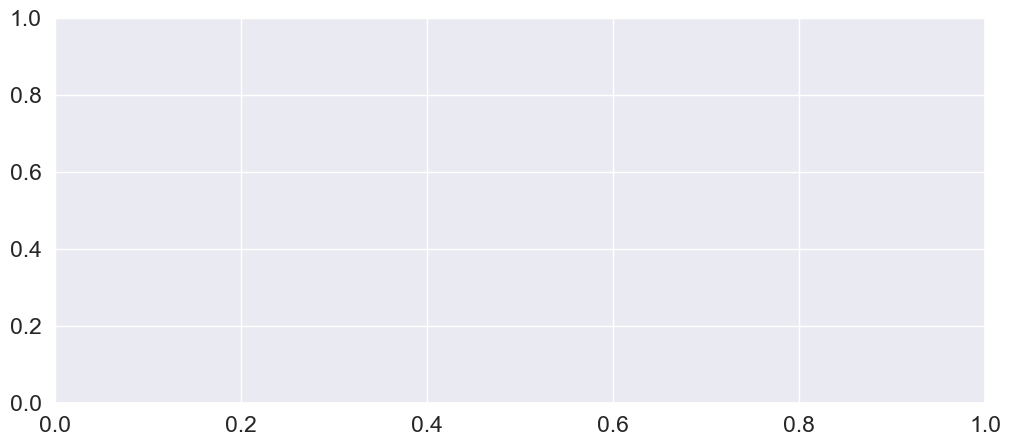

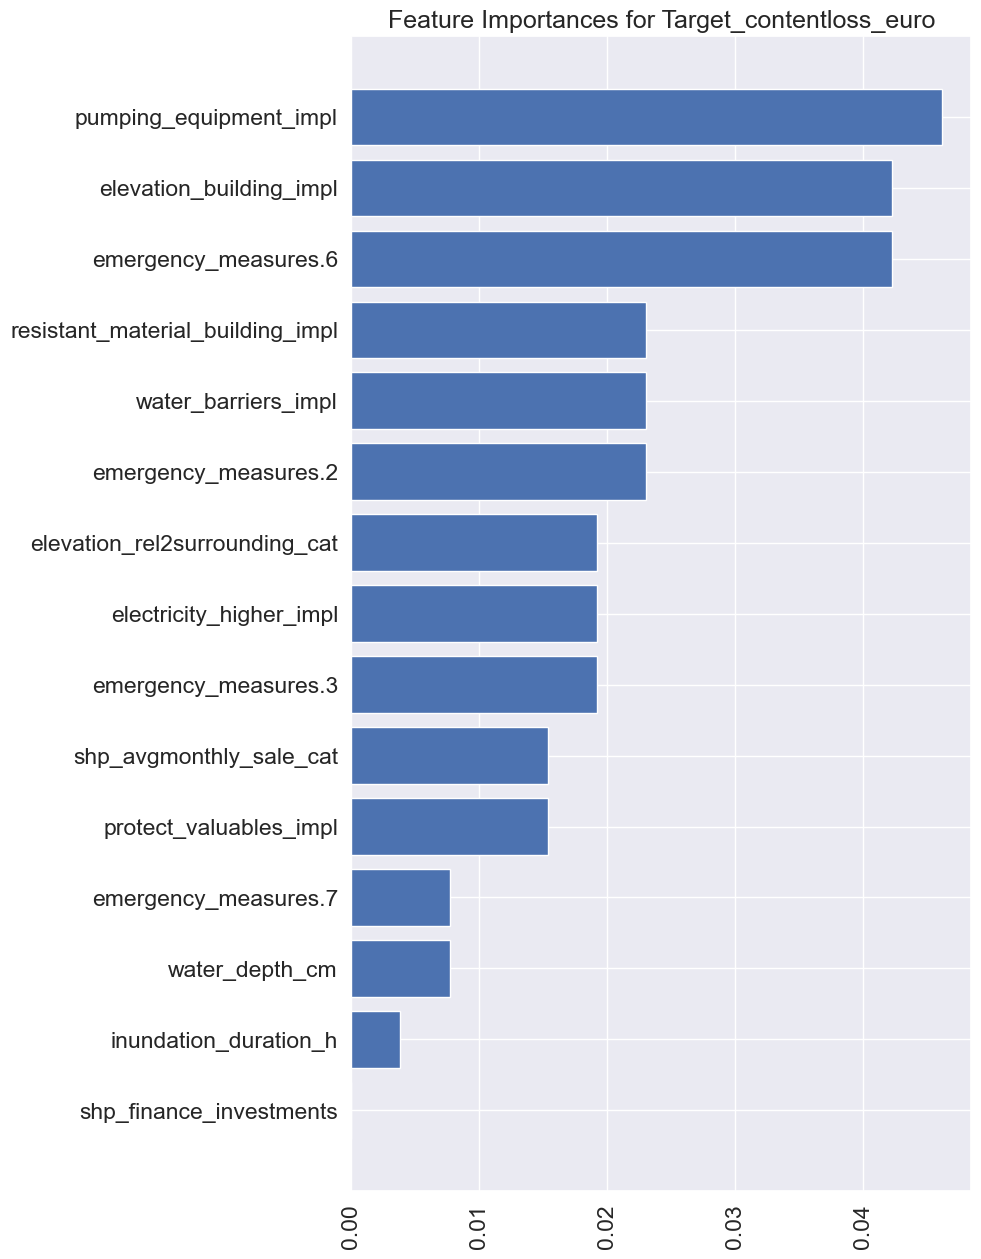

In [256]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))

importances = e.permutation_feature_importance(model_eval, X_test, y_test, repeats=5, seed=seed)

df_importance = pd.DataFrame(
    {"importances" : importances[0],
    "name" : X_train.columns.to_list(),
    }
    ) 
# ## coef of feature importances
# df_importance = pd.DataFrame({
#     "name" : X_unscaled.columns.to_list(),
#     "importances" : np.absolute(model_eval.coef_)[0],
#      }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0, : ] 
df_importance = df_importance.sort_values("importances", ascending=True)

plt.figure(figsize=(8, 15))
#plt.figsize=(22, 15)#fig, ax = plt.subplots(figsize=(12, 8))
plt.barh(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")
plt.show()

In [ ]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")

### Plot optimal number of features

In [ ]:
elastic_net_eval.c

In [ ]:
# cv results
cv_results = pd.DataFrame(elastic_net_eval.cv_results_)
cv_results


In [ ]:

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')